In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load energies from txt files

Data files can be created using "project_code.ipynb" or downloaded from [GitHub](https://github.com/MatejHav/quantum-project-group-2).

In [2]:
OF_data = np.genfromtxt('OpenFermion_energies.txt')
QK_data = np.genfromtxt('Qiskit_energies.txt')
theta_range, R_range = OF_data[1:,0], OF_data[0,1:]
theta_points,R_points = len(theta_range), len(R_range)
E_OF, E_QK = OF_data[1:,1:], QK_data[1:,1:]

In [3]:
def plot_results(R_range,theta_range,E0,E):
    plt.figure(figsize=(12,4))
    plt.subplot(121,box_aspect=0.7)
    plt.xlabel(r'Internuclear distance $R$ (Å)')
    plt.ylabel(r'Ground state energy $\langle E_0 \rangle$ (Ha)')
    plt.plot(R_range,E0)

    plt.subplot(122,aspect=1)
    plt.xlabel(r'Internuclear distance $R$ (Å)')
    plt.ylabel(r'$\theta$ ($\pi$ rad)')
    plt.plot(R_range,theta_range[np.argmin(E,axis=0)]/np.pi,c='white',lw=2)
    im = plt.imshow(E,extent=[min(R_range),max(R_range),min(theta_range)/np.pi,max(theta_range)/np.pi],
                    cmap='gnuplot',aspect=1.25,origin='lower')
    plt.colorbar(im,label=r'$\langle E \rangle$ (Ha)')
    plt.show()
    
def compare_hamiltonians(theta_range,R_range,E1,E2,save=0):
    plt.figure(figsize=(12,10))
    R_points = len(R_range)
    for i in range(R_points):
        plt.subplot(int(np.ceil(np.sqrt(R_points)+1)),int(np.sqrt(R_points)),i+1)
        plt.title(r"$R=$"+str(round(R_range[i],2))+" Å")
        plt.plot(theta_range,E1[:,i])
        plt.plot(theta_range,E2[:,i])
        plt.axis('off')
    if save: plt.savefig(f"Hamiltonian_comparison{save}.png")
    plt.show()

## Manual Qiskit Hamiltonian Correction

Rotation of 180$^\circ$ around the point $(\theta,E) = (\pi,0)$ is applied by negating the horizontal ($\theta$) and vertical ($E$) axes and verticle shift by applying a manually fitted array, `II_cor` to correct the difference between the two sets of Hamiltonians.

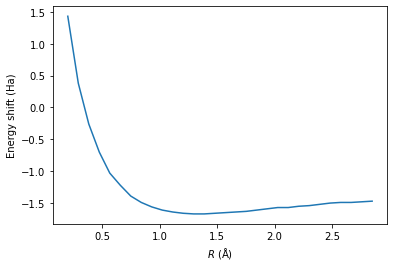

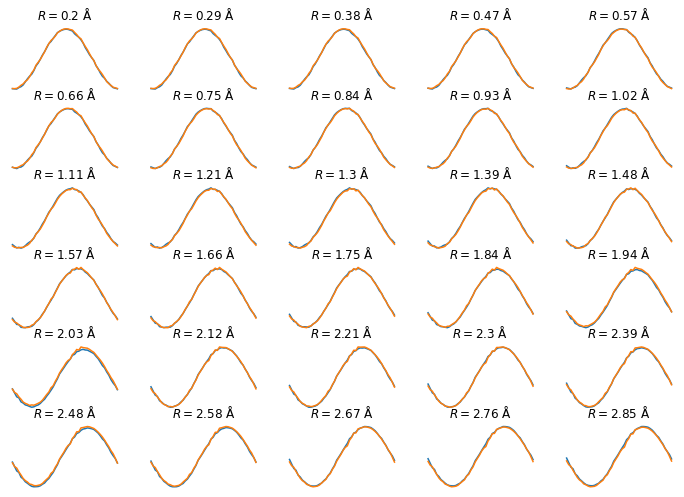

In [4]:
II_cor = np.array([ 1.43,  0.38, -0.26, -0.70, -1.03, -1.22, -1.39, -1.49, -1.56, -1.61,
                   -1.64, -1.66, -1.67, -1.67, -1.66, -1.65, -1.64, -1.63, -1.61, -1.59,
                   -1.57, -1.57, -1.55, -1.54, -1.52, -1.50, -1.49, -1.49, -1.48, -1.47])
II_cor_big = np.empty((theta_points,R_points))
for r in range(R_points):
    II_cor_big[:,r] = II_cor[r]
          
plt.figure()
plt.xlabel(r"$R$ (Å)"); plt.ylabel("Energy shift (Ha)")
plt.plot(R_range,II_cor)
plt.show()

compare_hamiltonians(theta_range,R_range,E_OF,II_cor_big-E_QK[::-1,:])

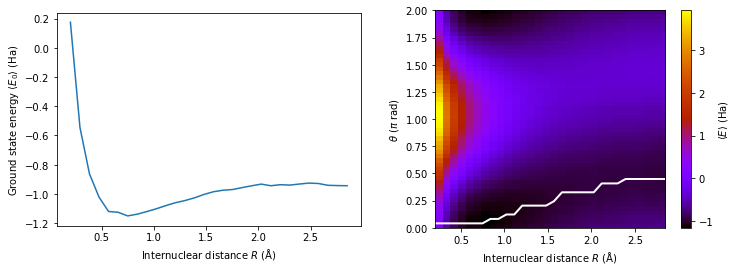

In [5]:
plot_results(R_range,theta_range,np.min(II_cor_big-E_QK[::-1,:],axis=0),II_cor_big-E_QK[::-1,:])

This closely matches the OpenFermion and theoretical results (figures 2 and 3 of [O'Malley](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031007) and figure 5d from [Xue](https://arxiv.org/abs/2107.00628)), proving this is indeed a working correction for the hydrogen molecule energies.

## Nuclear repulsion

Without the rotation, the shift energies are the nuclear repulsion energies

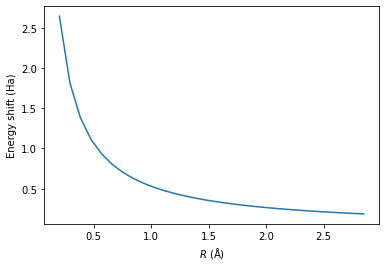

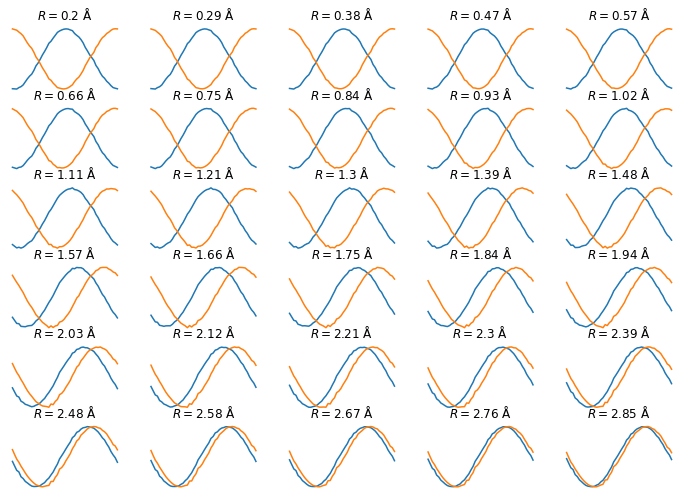

In [6]:
# Stored from PSI4DriverOld(molecule = molecule).run().nuclear_repulsion_energy for each R
nuclear_repulsion_energies = np.array([2.64588605335,1.8161111372106509,1.382535054903604,1.116082844322182,
                                       0.9357401895993901,0.8055716067942258,0.707195350664977,0.6302315856028747,
                                       0.5683755225714815,0.517576361194941,0.4751126659266254,0.4390883865359084,
                                       0.40814199759122344,0.3812705368802485,0.35771886035967365,0.3369075545429199,
                                       0.3183846288263486,0.30179231286981323,0.28684372167158884,0.27330612839590385,
                                       0.2609887603644558,0.24973375279788446,0.2394093464809672,0.22990470575925093,
                                       0.22112592376700288,0.2129929092217904,0.20543693586921014,0.19839869566166773,
                                       0.191826738867875,0.18567621427017544])
nre_big = np.empty((theta_points,R_points))
for r in range(R_points):
    nre_big[:,r] = nuclear_repulsion_energies[r]
          
plt.figure()
plt.xlabel(r"$R$ (Å)"); plt.ylabel("Energy shift (Ha)")
plt.plot(R_range,nuclear_repulsion_energies)
plt.show()

compare_hamiltonians(theta_range,R_range,E_OF,nre_big+E_QK)

The Hamiltonians still seem to be rotated 180$^\circ$ with respect to each other, however the curves are on the same heights now (specifically there minima, which dicate the ground state energy curve)

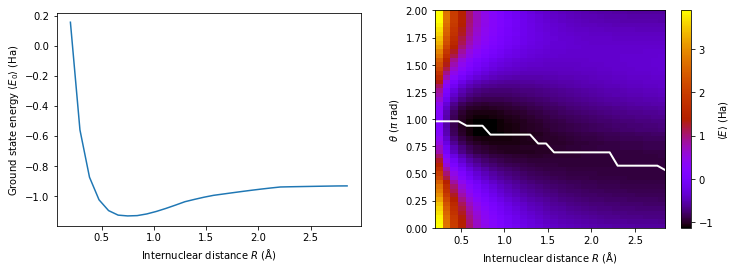

In [7]:
plot_results(R_range,theta_range,np.min(nre_big+E_QK,axis=0),nre_big+E_QK)

## Code for figures in the report and presentation

### Energy curves

We shift the incomplete qiskit results up to the same domain as the correct curves by 1.3 Ha to better see the small differences in the curves

In [8]:
from functools import partial
from qiskit_nature.drivers import Molecule
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)

from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.algorithms.pes_samplers import BOPESSampler

from qiskit_nature import settings
settings.dict_aux_operators = True

In [9]:
distance = partial(Molecule.absolute_distance, atom_pair=(1, 0)) # distance operation on molecule

# Define molecule and driver and create electronic structure problem
molecule = Molecule(geometry=[["H",[0.0,0.0,0.0]],["H",[0.0,0.0,0.74]]],charge=0,multiplicity=1,degrees_of_freedom=[distance])
driver = ElectronicStructureMoleculeDriver(molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYQUANTE)
es_problem = ElectronicStructureProblem(driver)

In [10]:
qubit_converter = QubitConverter(BravyiKitaevMapper())

# define numpy solver
solver_numpy = NumPyMinimumEigensolver()
me_gsc_numpy = GroundStateEigensolver(qubit_converter, solver_numpy)
bs_classical = BOPESSampler(
    gss=me_gsc_numpy, bootstrap=False, num_bootstrap=None, extrapolator=None
)
# execute
res_np = bs_classical.sample(es_problem, R_range)

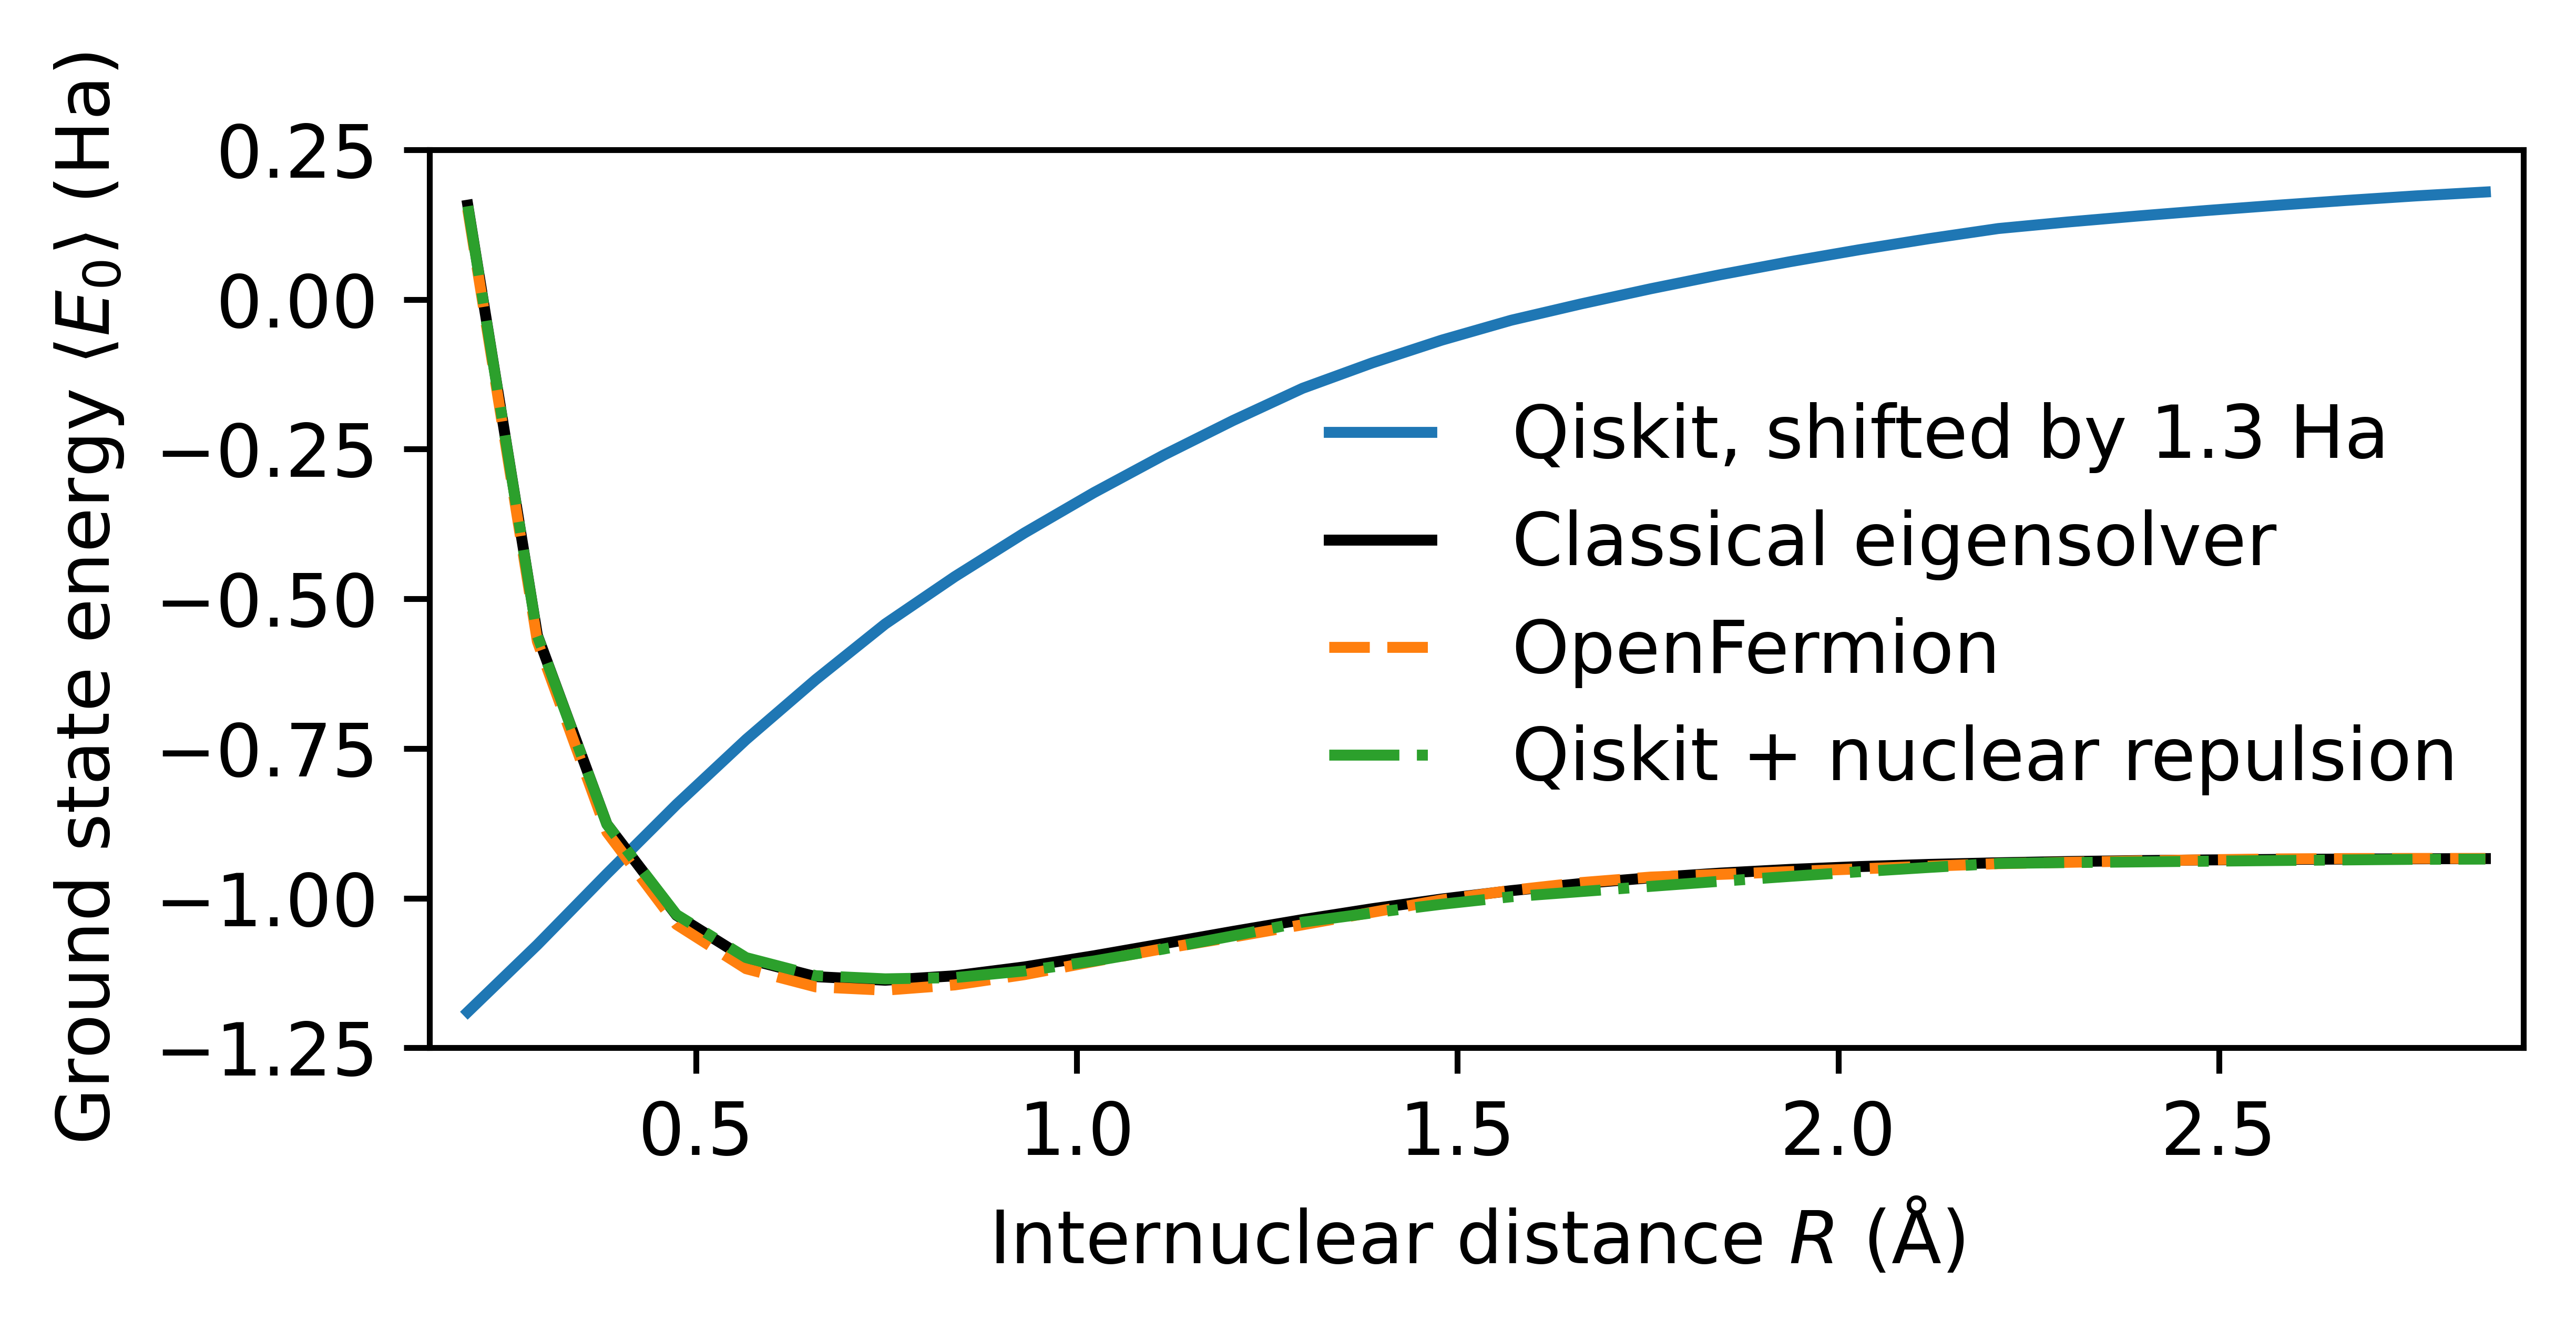

In [11]:
plt.figure(figsize=(5,2.5),dpi=1000)
plt.xlim(0.15,2.9); plt.ylim(-1.25,0.25)
plt.xlabel(r'Internuclear distance $R$ (Å)')
plt.ylabel(r'Ground state energy $\langle E_0 \rangle$ (Ha)')
plt.plot(R_range,1.3+np.min(E_QK,axis=0),label='Qiskit, shifted by 1.3 Ha')
plt.plot(res_np.points, res_np.energies,label="Classical eigensolver",c='black')
plt.plot(R_range,np.min(E_OF,axis=0),label='OpenFermion',ls='--')
plt.plot(R_range,np.min(E_QK+nre_big,axis=0),label='Qiskit + nuclear repulsion',ls='-.')
plt.legend(frameon=False,loc='center right',numpoints=2)
plt.tight_layout()
#plt.savefig('energy_curves.png')
plt.show()

### Hamiltonian comparison

Comparison between the uncorrected qiskit and the openfermion hamiltonians as function of $\theta$. Orange is OpenFermion and blue is Qiskit.

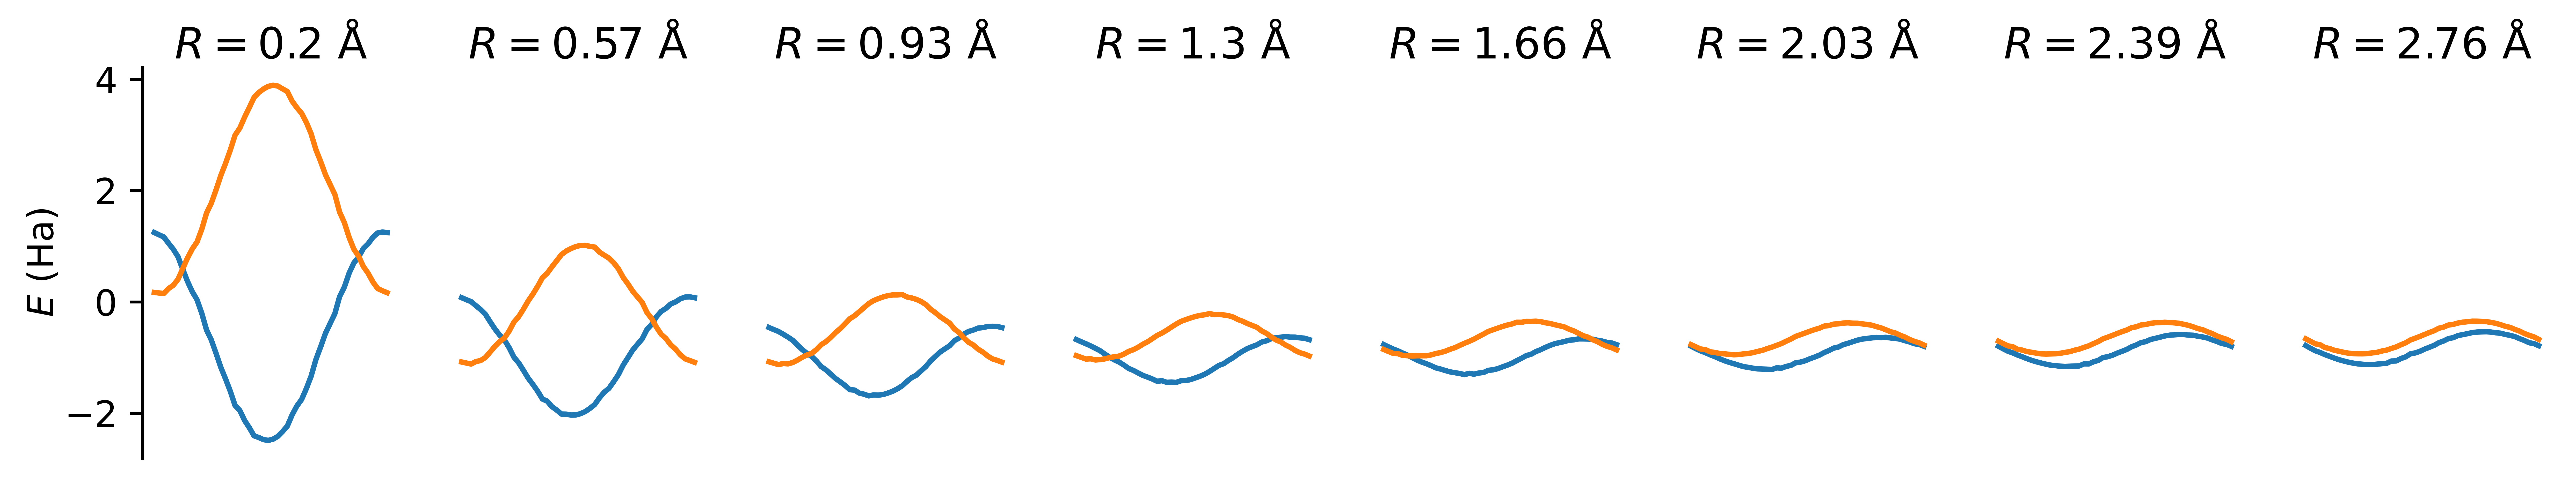

In [12]:
skip = 4

R_points = len(R_range[::skip])
plt.subplots(1,int(R_points),figsize=(12,2),sharey=True,dpi=1000)
ax = np.empty(R_points,dtype=object)
for i in range(R_points):
    ax[i] = plt.subplot(1,int(R_points),i+1)
    ax[i].set_title(r"$R=$"+str(round(R_range[::skip][i],2))+" Å",pad=-10)
    ax[i].plot(theta_range,E_QK[:,::skip][:,i])
    ax[i].plot(theta_range,E_OF[:,::skip][:,i])
    ax[i].get_xaxis().set_visible(False)
    if i==0:
        ax[i].set_ylabel("$E$ (Ha)",labelpad=1)
    else:
        ax[i].get_yaxis().set_visible(False)
        ax[i].spines['left'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
#plt.savefig("Hamiltonian_comparison.png")
plt.show()

### Individual energy curves 

In [13]:
def energy_curve_plot(R,E,label=None,color='C0',save=False,figsize=(5,2.5)):
    if save: dpi = 1000
    else: dpi = 150
    plt.figure(figsize=figsize,dpi=dpi)
    plt.xlabel(r'Internuclear distance $R$ (Å)')
    plt.ylabel(r'Ground state energy $\langle E_0 \rangle$ (Ha)')
    plt.plot(res_np.points, res_np.energies,label="Classical eigensolver",c='black',ls='--')
    plt.plot(R,E,label=label,c=color)
    if label: plt.legend()
    plt.tight_layout()
    if save: plt.savefig(f'energy_curve_{label}.png')
    plt.show()

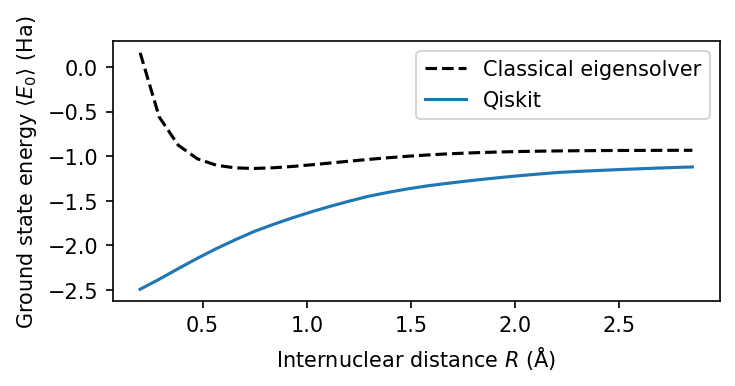

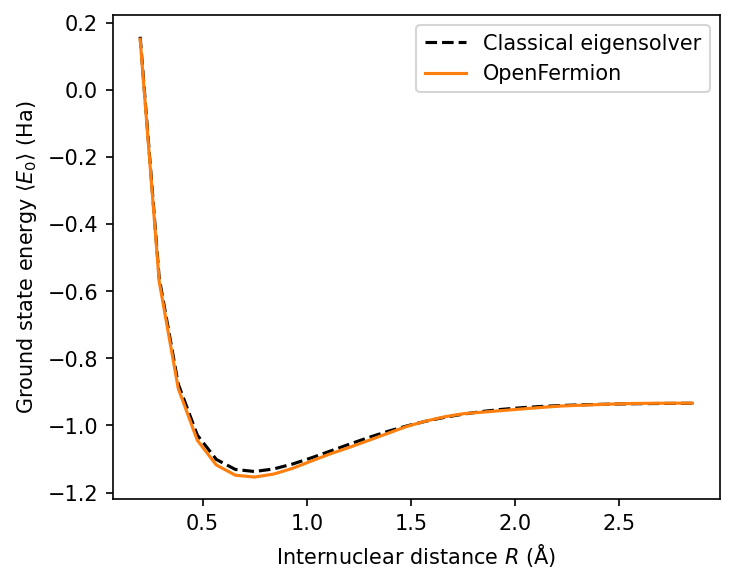

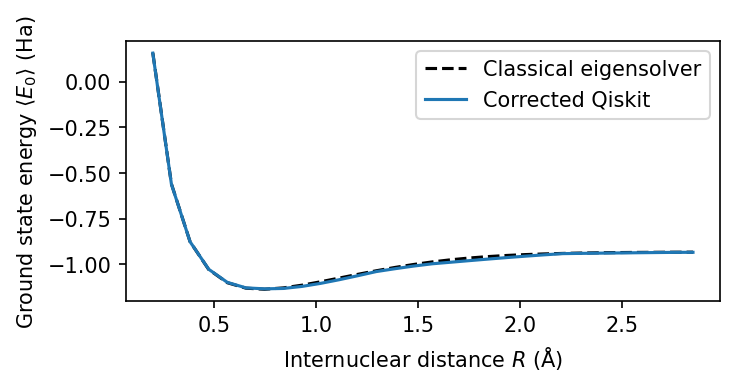

In [14]:
save = False
energy_curve_plot(R_range,np.min(E_QK,axis=0),label='Qiskit',color='C0',save=save,figsize=(5,2.5))
energy_curve_plot(R_range,np.min(E_OF,axis=0),label='OpenFermion',color='C1',save=save,figsize=(5,4))
energy_curve_plot(R_range,np.min(E_QK+nre_big,axis=0),label='Corrected Qiskit',color='C0',save=save)

### Error in VQE energy curves

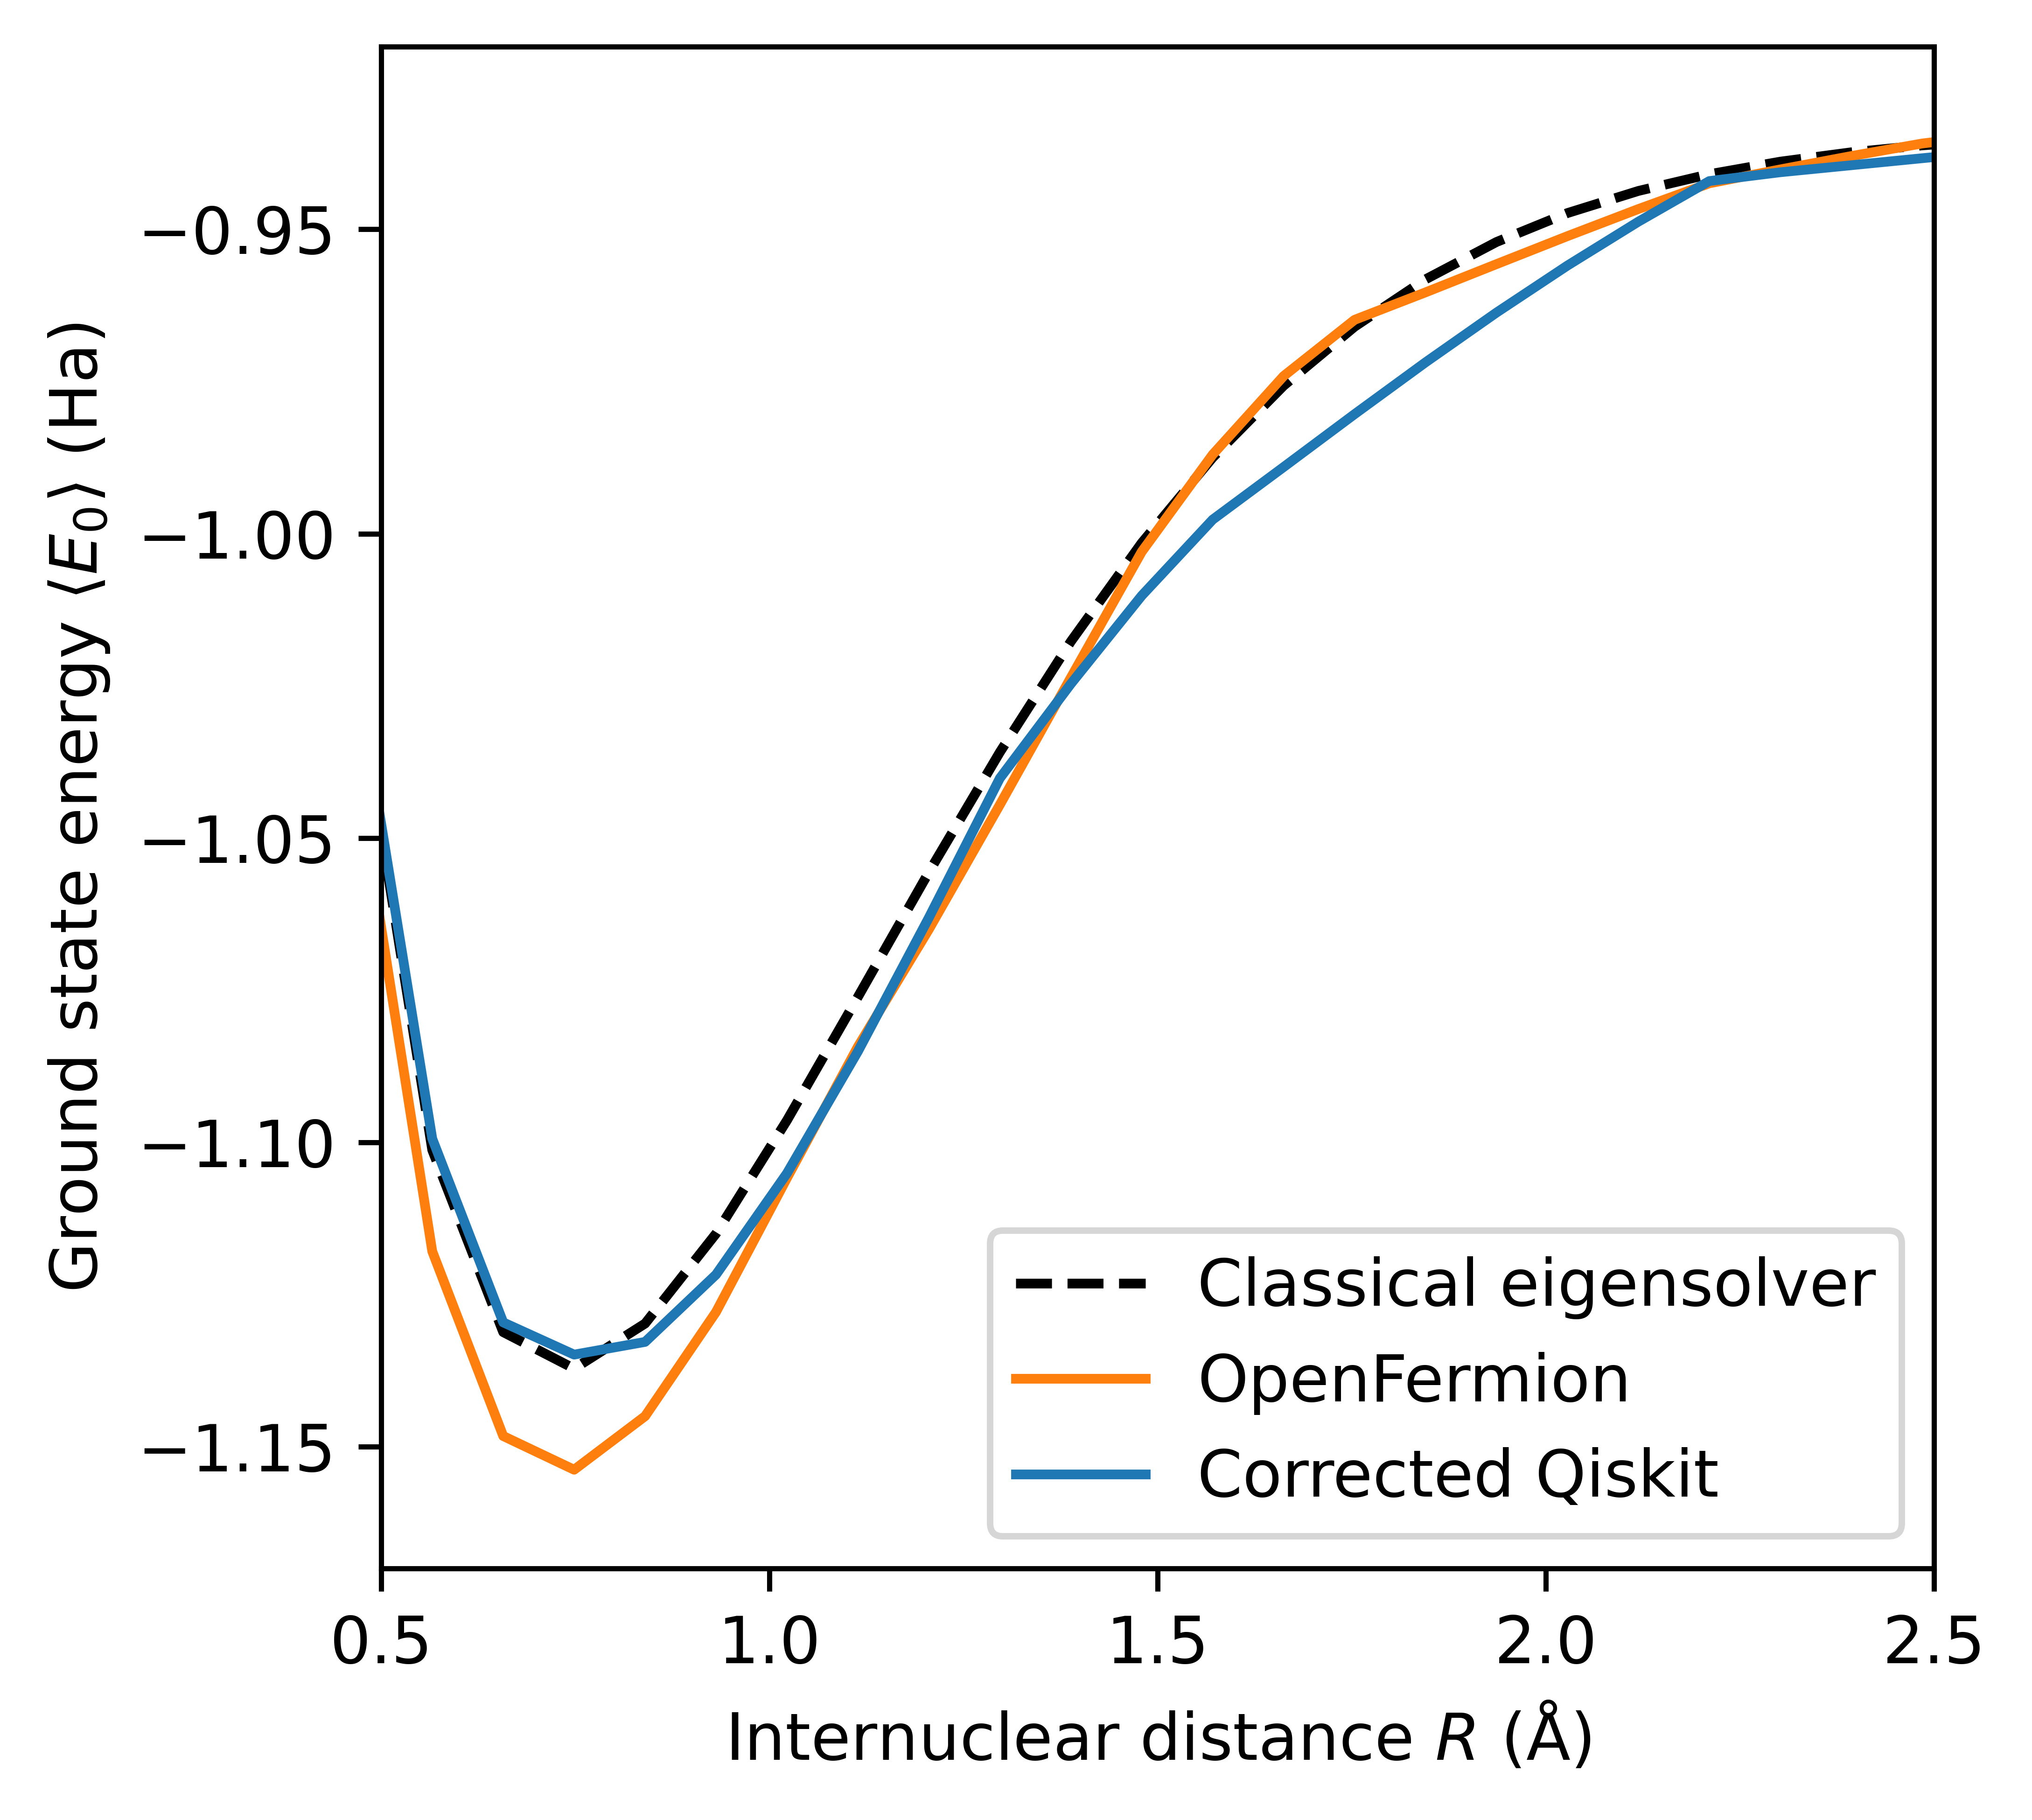

In [15]:
plt.figure(figsize=(4.5,4),dpi=1000)
plt.xlim((0.5,2.5)); plt.ylim((-1.17,-0.92))
plt.xlabel(r'Internuclear distance $R$ (Å)')
plt.ylabel(r'Ground state energy $\langle E_0 \rangle$ (Ha)')
plt.plot(res_np.points, res_np.energies,label="Classical eigensolver",c='black',ls='--')
plt.plot(R_range,np.min(E_OF,axis=0),label='OpenFermion',c='C1')
plt.plot(R_range,np.min(E_QK+nre_big,axis=0),label='Corrected Qiskit',c='C0')
plt.legend()
plt.tight_layout()
#plt.savefig('energy_curve_error.png')
plt.show()